# Assignment 4

### Recurrent neural network (RNN) 

Use the Google stock prices dataset and design a time
seriesanalysis and prediction system using RNN

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
df = pd.read_csv('google_stock_price_train.csv', thousands=",")
df

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,623400
1254,12/27/2016,790.68,797.86,787.66,791.55,789100
1255,12/28/2016,793.70,794.23,783.20,785.05,1153800
1256,12/29/2016,783.33,785.93,778.92,782.79,744300


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


In [4]:
# Convert to datetime obj
df['Date'] = pd.to_datetime(df['Date'])

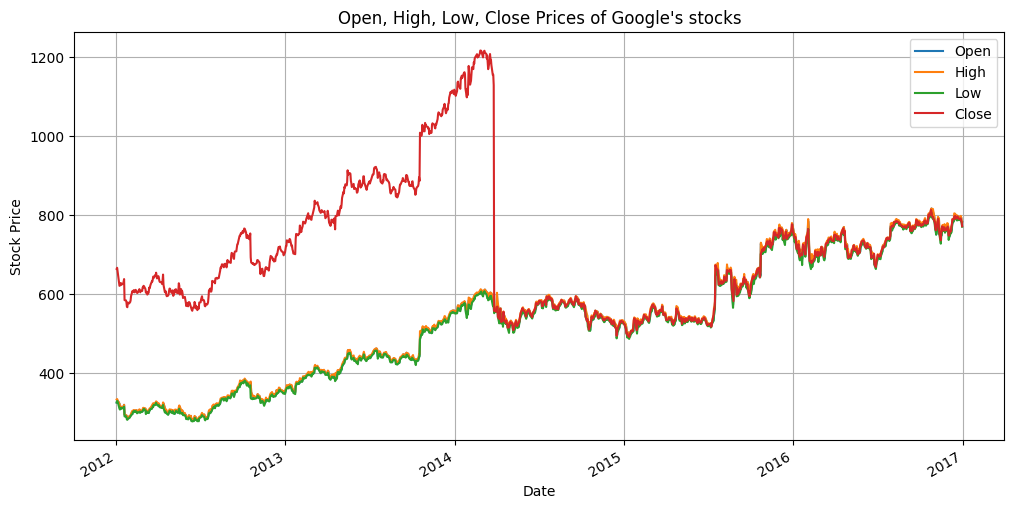

In [5]:
fig = df.plot(
    x="Date",
    y=["Open", "High", "Low", "Close"],
    figsize=(12, 6),
    title="Open, High, Low, Close Prices of Google's stocks"
)
fig.set_xlabel("Date")
fig.set_ylabel("Stock Price")
plt.grid(True)
plt.show()

In [6]:
# Select features, not date
data = df.drop("Date", axis=1)

In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [8]:
# create_sequences is used in building many pairs of:
# x: past 60 days of features (Open, High, Low, Close)
# y: today's Close price
def create_sequences(data, target_col_index, seq_len=60):
    x, y = [], []
    for i in range(seq_len, len(data)):
        x.append(data[i-seq_len:i])             # the last 60 days (past context)
        y.append(data[i, target_col_index])     # the actual price to predict (e.g., today)
    return np.array(x), np.array(y)

x, y = create_sequences(scaled_data, target_col_index=3)
x

array([[[0.08581368, 0.09640129, 0.09044931, 0.23757287, 0.29525831],
        [0.09701243, 0.09834351, 0.09823458, 0.24151427, 0.22993592],
        [0.09433366, 0.09251685, 0.09408623, 0.22878051, 0.26361233],
        ...,
        [0.07846566, 0.07903337, 0.0783452 , 0.21546794, 0.14593512],
        [0.08034452, 0.08276841, 0.08330808, 0.21229828, 0.16105326],
        [0.08497656, 0.08751191, 0.08921806, 0.22430164, 0.20379656]],

       [[0.09701243, 0.09834351, 0.09823458, 0.24151427, 0.22993592],
        [0.09433366, 0.09251685, 0.09408623, 0.22878051, 0.26361233],
        [0.09156187, 0.08881917, 0.08800576, 0.21641884, 0.21617942],
        ...,
        [0.08034452, 0.08276841, 0.08330808, 0.21229828, 0.16105326],
        [0.08497656, 0.08751191, 0.08921806, 0.22430164, 0.20379656],
        [0.08627874, 0.08564439, 0.08283452, 0.21420007, 0.15438526]],

       [[0.09433366, 0.09251685, 0.09408623, 0.22878051, 0.26361233],
        [0.09156187, 0.08881917, 0.08800576, 0.21641884, 0.2

In [9]:
split = int(len(x) * 0.8)
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
# Define a Sequential model — layers will be added in order
model = Sequential([

    # First LSTM layer:
    # - 64 units (memory cells)
    # - return_sequences=True: output the full sequence (needed when stacking LSTMs)
    # - input_shape: (timesteps, features) → here it's (60, 4)
    LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),

    # Dropout layer to reduce overfitting:
    # - randomly drops 20% of the units during training
    Dropout(0.2),

    # Second LSTM layer:
    # - 64 units
    # - return_sequences=False by default → outputs only the last hidden state
    LSTM(64),

    # Another dropout layer for regularization
    Dropout(0.2),

    # Output layer:
    # - 1 neuron since we are predicting a single continuous value (the stock's close price)
    Dense(1)
])

# Compile the model:
# - Optimizer: 'adam' adjusts learning rate automatically
# - Loss: 'mean_squared_error' is standard for regression problems
model.compile(optimizer='adam', loss='mean_squared_error')

# Display a summary of the model's architecture and parameters
model.summary()


/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,009 (199.25 KB)

 Trainable params: 51,009 (199.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018 - val_loss: 8.1185e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0021 - val_loss: 2.7974e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014 - val_loss: 2.7640e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022 - val_loss: 5.7509e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - val_loss: 4.7079e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019 - val_loss: 2.8170e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026 - val_loss: 2.9700e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 3.9306e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - val_loss: 2.8948e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0021 - val_loss: 2.7199e-04
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014 - val_loss: 9.9799e-04
Epoch 12/50
30/30 ━

In [18]:
y_pred = model.predict(x_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [19]:
# dummy scaler to inverse transform Close column only
close_scaler = MinMaxScaler()

# copy over the min_ and scale_ values for the Close column from the original scaler (index 3)
close_scaler.min_, close_scaler.scale_ = scaler.min_[3:4], scaler.scale_[3:4]

In [20]:
predicted_values = close_scaler.inverse_transform(y_pred)
actual_values = close_scaler.inverse_transform(y_test.reshape(-1, 1))

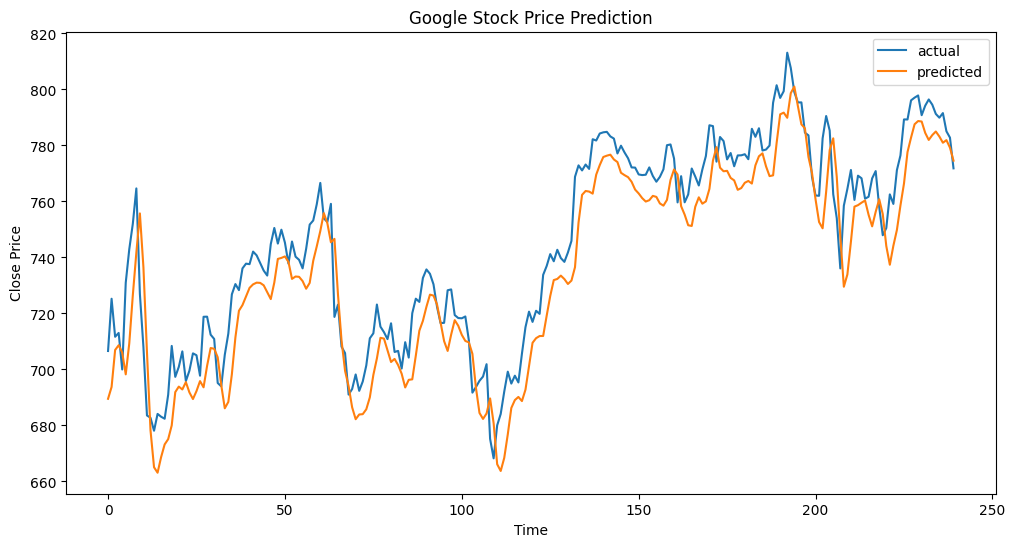

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='actual')
plt.plot(predicted_values, label='predicted')
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [22]:
# metrics
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

print('RMSE: ', rmse)
print('MAE: ', mae)
print('R2 Score: ', r2)

RMSE:  13.985475130276548
MAE:  11.679479359944658
R2 Score:  0.8361938096352056
